# Search engines

This notebook shows how to use [PyTerrier](https://github.com/terrier-org/pyterrier) on the [CORD19 corpus](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7251955/) and the [TREC Covid test collection](https://ir.nist.gov/covidSubmit/).
Hereafter we are going to see how to:
- index a collection
- access an index
- search an index
- compare the performances of indexing approaches
- learn ranking
- evaluate ranking

The notebook in mainly based on the tutorials at this [link](https://github.com/terrier-org/cikm2021tutorial/tree/main/notebooks), which are part of the tutorial series "[IR From Bag-of-words to BERT and Beyond through Practical Experiments](https://github.com/terrier-org/cikm2021tutorial/)" created for the [CIKM 2021](https://www.cikm2021.org/).

## Tools installation and configuration

PyTerrier is a Python framework, but uses the underlying [Terrier information retrieval toolkit](http://terrier.org) for many indexing and retrieval operations. While PyTerrier was new in 2020, Terrier is written in Java and has a long history dating back to 2001. PyTerrier makes it easy to perform IR experiments in Python, but using the mature Terrier platform for the expensive indexing and retrieval operations. 

PyTerrier is installed as follows. This might take a few minutes, in the meanwhile you can take a look at [PyTerrier documentation](https://pyterrier.readthedocs.io/en/latest/).

In [1]:
!pip install -q python-terrier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 13.1 MB/s eta

The next step is to initialise PyTerrier. This is performed using PyTerrier's `init()` method. The `init()` method is needed as PyTerrier must download Terrier's jar file and start the Java virtual machine. We prevent `init()` from being called more than once by checking `started()`.

In [2]:
import pyterrier as pt
if not pt.started():
  pt.init()

terrier-assemblies 5.7 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.7 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



## Introduction to document indexing and searching

Much of PyTerrier's view of the world is wrapped up in Pandas dataframes. Let's consider some textual documents in a dataframe.

We can start importing Pandas, a well known Python library to manage tabular data. 
You can find Pandas' documentation at the following [link](https://pandas.pydata.org).


In [3]:
import pandas as pd

We can set the length of the displayed output to avoid truncating too much text

In [4]:
pd.set_option('display.max_colwidth', 150)

### Documents

Finally we can create some sample documents to store in a `DataFrame

In [5]:
docs_df = pd.DataFrame(
    [
        ["d1", "This is the first article in my collection of articles."],
        ["d2", "This is another article in my collection."],
        ["d3", "The topic of this third article is unknown."]
    ], 
    columns=["docno", "text"]
)
docs_df

,docno,text
0,d1,This is the first article in my collection of articles.
1,d2,This is another article in my collection.
2,d3,The topic of this third article is unknown.


### Indexing

Before any search engine can estimate which documents are most likely to be relevant for a given query, it must index the documents. 

In the following cell, we index the dataframe's documents. The index, with all its data structures, is written into a directory that we will call `index_3docs`. You can see it in the Google colab files folder on the left.

In [6]:
indexer = pt.DFIndexer("./index_3docs", overwrite=True)
index_ref = indexer.index(docs_df["text"], docs_df["docno"])
index_ref.toString()

'./index_3docs/data.properties'

`IndexRef` provides the location where the index is stored. Indeed, we can look in the `index_3docs` directory and see that it has created various files: 

In [7]:
!ls -lh index_3docs/

total 44K
-rw-r--r-- 1 root root    4 Mar 20 09:58 data.direct.bf
-rw-r--r-- 1 root root   51 Mar 20 09:58 data.document.fsarrayfile
-rw-r--r-- 1 root root    5 Mar 20 09:58 data.inverted.bf
-rw-r--r-- 1 root root  516 Mar 20 09:58 data.lexicon.fsomapfile
-rw-r--r-- 1 root root  273 Mar 20 09:58 data.lexicon.fsomaphash
-rw-r--r-- 1 root root   24 Mar 20 09:58 data.lexicon.fsomapid
-rw-r--r-- 1 root root   33 Mar 20 09:58 data.meta-0.fsomapfile
-rw-r--r-- 1 root root   24 Mar 20 09:58 data.meta.idx
-rw-r--r-- 1 root root   48 Mar 20 09:58 data.meta.zdata
-rw-r--r-- 1 root root 4.1K Mar 20 09:58 data.properties


We can now load the index:

In [8]:
index = pt.IndexFactory.of(index_ref)

This is a Terrier index structure, which provides methods such as:
 - `getCollectionStatistics()`
 - `getInvertedIndex()`
 - `getLexicon()`

Note Terrier is written in Java. (Yes, yes... I know... Java... 🤢) 
The Javadoc documentation is here: 
http://terrier.org/docs/current/javadoc/org/terrier/structures/Index.html

Let's see what is returned by the `CollectionStatistics()` method:

In [9]:
print(index.getCollectionStatistics().toString())

Number of documents: 3
Number of terms: 6
Number of postings: 9
Number of fields: 0
Number of tokens: 10
Field names: []
Positions:   false



Ok, that seems fair – we have 3 documents. But why only 6 terms? 
Let's check the [`Lexicon`](http://terrier.org/docs/current/javadoc/org/terrier/structures/Lexicon.html), which is our vocabulary. The `Lexicon` contains a set of terms, so we need to iterate over it:

In [10]:
for kv in index.getLexicon():
    print(kv.getKey(),": ", kv.getValue().toString())

articl :  term1 Nt=3 TF=4 maxTF=2 @{0 0 0}
collect :  term0 Nt=2 TF=2 maxTF=1 @{0 0 7}
first :  term2 Nt=1 TF=1 maxTF=1 @{0 1 3}
third :  term4 Nt=1 TF=1 maxTF=1 @{0 1 5}
topic :  term3 Nt=1 TF=1 maxTF=1 @{0 2 1}
unknown :  term5 Nt=1 TF=1 maxTF=1 @{0 2 5}


We see the terms and the statistics collected about each.
Note that stopwords were removed and Porter's stemmer has been applied.
Here:
 - `Nt` is the number of unique documents that each term occurs in – this is useful for calculating IDF.
 - `TF` is the total number of occurrences of term in corpus.

Finally, we can use the square bracket notation to lookup terms in the lexicon:


In [11]:
index.getLexicon()["articl"].toString()

'term1 Nt=3 TF=4 maxTF=2 @{0 0 0}'

And we can see how many times this term is used in each document that it occurs in (by iterating over the posting lists):

In [12]:
pointer = index.getLexicon()["articl"]
for posting in index.getInvertedIndex().getPostings(pointer):
    print(f'{posting.toString()} doclen = {posting.getDocumentLength()}')

ID(0) TF(2) doclen = 4
ID(1) TF(1) doclen = 2
ID(2) TF(1) doclen = 4


We can see that `"article"` occurs in each of the three documents. 

### Searching an Index

Now that we have indexed our documents, we can run a search over the document collection:

In [13]:
query = "articles"

br = pt.BatchRetrieve(index, wmodel="TF_IDF")
br.search(query)

,qid,docid,docno,rank,score,query
0,1,0,d1,0,0.710059,articles
1,1,1,d2,1,0.652174,articles
2,1,2,d3,2,0.504202,articles


Here we used the TF-IDF weighting formula to rank the results. 

The `search()` method returns a dataframe with columns:
 - `qid`: the query identifier
 - `docid`: integer identifier for document 
 - `docno`: string identifier for document
 - `rank`: rank position
 - `score`: tf-idf score
 - `query`: the input query

### Multiple searches

We can also run multiple queries at once:

In [14]:
queries = pd.DataFrame([["query1", "articles"], ["query2", "first article"], ["query3", "unknown"]], columns=["qid", "query"])
br(queries)

,qid,docid,docno,rank,score,query
0,query1,0,d1,0,0.710059,articles
1,query1,1,d2,1,0.652174,articles
2,query1,2,d3,2,0.504202,articles
3,query2,0,d1,0,1.718463,first article
4,query2,1,d2,1,0.652174,first article
5,query2,2,d3,2,0.504202,first article
6,query3,2,d3,0,1.008403,unknown


## Loading a real dataset

We'll now load a real dataset of COVID-19 related scientific articles (called CORD19) that is available as an example in PyTerrier

In [15]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')

We just downloaded the data. Now we index and save the dataset.

The CORD19 corpus contains articles about the COVID-19, we are going to retrieve only the abstract of these articles to compose our documents. The indexing will take a while to run since there are almost 200,000 articles. 

In [16]:
pt_index_path = './terrier_cord19'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(cord19.get_corpus_iter(), fields=('abstract',), meta=('docno',))

[INFO] [starting] building docstore
[INFO] If you have a local copy of https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/80d664e496b8b7e50a39c6f6bb92e0ef
[INFO] [starting] https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv
docs_iter:   0%|                                    | 0/192509 [00:00<?, ?doc/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 0.00/269M [00:00<?, ?B/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.1%| 270k/269M [00:00<02:12, 2.03MB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.9%| 2.29M/269M [00:00<00:28, 9.24MB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 3.0%| 8.09M/269M [00:00<00:11, 23.2MB/s]
https://ai2-semanticscholar-cord

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

<ipython-input-16-4231c0f9a7ad>:3: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use constructor instead
  index_ref = indexer.index(cord19.get_corpus_iter(), fields=('abstract',), meta=('docno',))


09:59:26.035 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed
10:01:01.742 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 54937 empty documents


### Querying the index

Now load the index and print the statistics:

In [17]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

Number of documents: 192509
Number of terms: 151235
Number of postings: 11554033
Number of fields: 1
Number of tokens: 17728468
Field names: [abstract]
Positions:   false



Let's run a query:

In [18]:
query = "chemical reactions"

tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
tfidf.search(query)

,qid,docid,docno,rank,score,query
0,1,18717,iavwkdpr,0,11.035982,chemical reactions
1,1,171636,v3blnh02,1,10.329726,chemical reactions
2,1,147193,ei4rb8fr,2,10.317138,chemical reactions
3,1,121217,msdycum2,3,9.653734,chemical reactions
4,1,170863,sj8i9ss2,4,9.500211,chemical reactions
...,...,...,...,...,...,...
995,1,2428,38aabxh1,995,3.790183,chemical reactions
996,1,14752,u709r8ss,996,3.790183,chemical reactions
997,1,20074,wxi1xsbo,997,3.790183,chemical reactions
998,1,117156,ts3obwts,998,3.790183,chemical reactions


Instead of ranking documents by their TF-IDF score, we could also use the BM25 score which is known to produce high quality search results.

In [19]:
query = "chemical reactions"

bm25 = pt.BatchRetrieve(index, wmodel="BM25")
bm25.search(query)

,qid,docid,docno,rank,score,query
0,1,18717,iavwkdpr,0,20.011607,chemical reactions
1,1,171636,v3blnh02,1,18.723538,chemical reactions
2,1,147193,ei4rb8fr,2,18.700723,chemical reactions
3,1,121217,msdycum2,3,17.498245,chemical reactions
4,1,170863,sj8i9ss2,4,17.228355,chemical reactions
...,...,...,...,...,...,...
995,1,88455,cuvqym6y,995,6.855393,chemical reactions
996,1,137287,8kfjw8ai,996,6.855393,chemical reactions
997,1,140078,kebvzeg4,997,6.855393,chemical reactions
998,1,148411,hhcfrjrn,998,6.855393,chemical reactions


Note that the first 5 documents in the ranking are the same as they were for TF-IDF. 

### Evaluating retrieval

So far, we have been creating search engine models, but we haven't decided if any of them are actually any good. In order to determine how good a ranking is, we need annotations telling us which documents are actually relevant for a particular query. 

The CORD19 dataset contains set of queries and relevance assessments (aka qrels)for this purpose. 

For historical reasons, the queries are called "topics". Let's have a look at the first 10 queries:

In [20]:
queries = cord19.get_topics(variant='title')
queries.head(10)

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [7.77MB/s]


,qid,query
0,1,coronavirus origin
1,2,coronavirus response to weather changes
2,3,coronavirus immunity
3,4,how do people die from the coronavirus
4,5,animal models of covid 19
5,6,coronavirus test rapid testing
6,7,serological tests for coronavirus
7,8,coronavirus under reporting
8,9,coronavirus in canada
9,10,coronavirus social distancing impact


And the first 10 relevance judgements (called qrels):

In [21]:
qrels = cord19.get_qrels()
qrels.head(10)

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt: [00:00] [1.14MB] [3.67MB/s]


,qid,docno,label,iteration
0,1,005b2j4b,2,4.5
1,1,00fmeepz,1,4
2,1,010vptx3,2,0.5
3,1,0194oljo,1,2.5
4,1,021q9884,1,4
5,1,02f0opkr,1,1
6,1,047xpt2c,0,3.5
7,1,04ftw7k9,0,1
8,1,05qglt1f,0,1
9,1,05vx82oo,0,3


We can give a look at the distribution of the relevance scores in the data set. To do so we train the count of occurrences of each label, sort the values by label and plot these values in a bat plot (note the log-scale on the y-axis):

<Axes: >

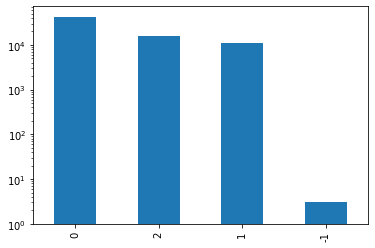

In [22]:
qrels['label'].value_counts().plot(kind='bar', log=True)

Note that there are some relevance judgements taking the value of -1. In the original documentation of the data set (https://ir-datasets.com/cord19.html) only the values 0, 1, and 2 are accepted, so the -1 must be errors in the annotation, since they are only 2 we can drop the corresponding qrels.

To drop the undesired we simply have to retain all the qrels with a label different from -1

In [23]:
qrels = qrels[qrels['label'] != -1]

The qrels contain information on the relevance labels for the query-document pairs. To do our evaluation we need to load also the queries we are going to use to test our retrieval system. For historical reasons, queries are called "topics" in this context.

Let's collect the topics in the CORD-19 corpus:

In [24]:
topics = cord19.get_topics(variant='title')
topics

,qid,query
0,1,coronavirus origin
1,2,coronavirus response to weather changes
2,3,coronavirus immunity
3,4,how do people die from the coronavirus
4,5,animal models of covid 19
5,6,coronavirus test rapid testing
6,7,serological tests for coronavirus
7,8,coronavirus under reporting
8,9,coronavirus in canada
9,10,coronavirus social distancing impact


Now let us use these queries and relevance judgements to compare different retrieval functions to see how well they perform at ranking documents in the collection. We compare BM25 and TF-IDF in terms of two common ranking evaluation measures (MAP and NDCG), where higher values indicate a better ranking:  

In [25]:
pt.Experiment(
    [tfidf, bm25],
    topics,
    qrels,
    eval_metrics=["map", "ndcg"]
)

,name,map,ndcg
0,BR(TF_IDF),0.180002,0.370767
1,BR(BM25),0.181478,0.373328


How were those scores calculated? We can have a look at the score and corresponding relevance labels for individual query document pairs as follows:

In [26]:
# Rank the documents for each query using the TF-IDF scoring function:
results = tfidf(cord19.get_topics(variant='title'))
# Add the relevance labels (qrels) to the table:
results = results.merge(qrels, on=["qid", "docno"], how="left").fillna(0)
# Display the output 
results

,qid,docid,docno,rank,score,query,label,iteration
0,1,175892,zy8qjaai,0,7.080599,coronavirus origin,1.0,1
1,1,82224,8ccl9aui,1,6.775667,coronavirus origin,2.0,1
2,1,135326,ne5r4d4b,2,6.683114,coronavirus origin,0.0,1.5
3,1,122804,75773gwg,3,6.590340,coronavirus origin,2.0,5
4,1,122805,kn2z7lho,4,6.590340,coronavirus origin,2.0,3
...,...,...,...,...,...,...,...,...
49995,50,133596,hf4hxf9u,995,5.271597,mrna vaccine coronavirus,0.0,0
49996,50,158429,0xf48prl,996,5.271451,mrna vaccine coronavirus,0.0,0
49997,50,277,3gwm1c2f,997,5.270141,mrna vaccine coronavirus,0.0,0
49998,50,10212,o7fv8ww0,998,5.270141,mrna vaccine coronavirus,0.0,0


## Pipelines

For this part of the notebook, we'll be using a different (pre-built) Terrier index with term position information, which was built uisng the following code. (We wont run it now since it would take a while to run.)
```python
pt_index_path = './terrier_cord19_blocks'
indexer = pt.index.IterDictIndexer(pt_index_path blocks=True)
index_ref = indexer.index(cord19.get_corpus_iter(), fields=('abstract',), meta=('docno',))
```

However, its just as quick to use the pre-built index from the Terrier Data Repository. We use the ['terrier_stemmed_positions'](http://data.terrier.org/trec-covid.dataset.html#terrier_stemmed_positions) index variant.

In [27]:
index = pt.IndexFactory.of(
    pt.get_dataset('trec-covid').get_index('terrier_stemmed_positions')
)

data.lexicon.fsomapfile:   0%|          | 0.00/14.2M [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/4.38M [00:00<?, ?iB/s]

data.direct.bf:   0%|          | 0.00/50.6M [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/537 [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/4.56M [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.37k [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/48.7M [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/1.46M [00:00<?, ?iB/s]

data.meta-0.fsomapfile:   0%|          | 0.00/5.29M [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/0.99k [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/619k [00:00<?, ?iB/s]

#### Operators

`BatchRetrieve` objects can be combined using some special operators. These combinations are called pipelines. 

Hereafter we are going to see three operators:
- Composition
- Rank cut-off
- Union

Before moving to the actual operators se define three retrievers using the index we have just created. We are going to define retrievers using 
- TF
- TF-IDF
- BM25

In [28]:
tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

##### Composition

The first operator we are going to see is the composition. This operator allow to re-rank the output of one retriever using a second retriever. 

To use it, we simply need to compose two retrievers using the  `>>` operator. 

Given the first query in the topics we loaded before

In [29]:
query = 'chemical'

Let's see first what TF alone would retrieve

In [30]:
tf.search(query)

,qid,docid,docno,rank,score,query
0,1,37756,jn5qi1jb,0,11.0,chemical
1,1,134017,0smev8vt,1,9.0,chemical
2,1,141638,km3bvc8h,2,9.0,chemical
3,1,2524,ifebw24e,3,8.0,chemical
4,1,12778,i3xcjagk,4,7.0,chemical
...,...,...,...,...,...,...
995,1,50034,04o4bf4t,995,1.0,chemical
996,1,50125,5g018q6w,996,1.0,chemical
997,1,50805,l3s85iul,997,1.0,chemical
998,1,50975,poz8l5jf,998,1.0,chemical


Now let's compose the TF with the BM25, in this way we will re-rank the TF-IDF results using BM25.

First we create a composition an then run the search using the composition pipeline.

In [31]:
composition = tf >> bm25

composition.search(query)

,qid,docid,docno,rank,score,query
0,1,15671,8hykq71k,0,12.646089,chemical
1,1,37756,jn5qi1jb,1,12.595498,chemical
2,1,87397,ck6clsty,2,12.425298,chemical
3,1,134017,0smev8vt,3,12.414508,chemical
4,1,18717,iavwkdpr,4,12.221431,chemical
...,...,...,...,...,...,...
995,1,7551,itfnu5dz,995,3.360914,chemical
996,1,14973,ie7mc8ti,996,3.226529,chemical
997,1,31083,e170ymw3,997,2.729883,chemical
998,1,87955,t473tbm9,998,2.677723,chemical


As you can see some documents have been further re-ordered by the BM25

##### Rank cut-off

The second operator we are going to see is the rank cut-off. This operator allow to retain only the top *n* results. 

To use it, we simply need to compose a new retriever applying the `% n` operator to an existing retriever (with *n* being the number of results we want to retain. This is useful to do an early pruning of the the retreived results.

Let's retain the top 10 results using the TF-IDF score.

First we define the rank cut-off pipeline using the TF retriever, then we use it to answer the query.

In [32]:
tf_idf_cut = tf_idf % 10

tf_idf_cut.search(query)

,qid,docid,docno,rank,score,query
0,1,15671,8hykq71k,0,6.932276,chemical
1,1,37756,jn5qi1jb,1,6.904544,chemical
2,1,87397,ck6clsty,2,6.811244,chemical
3,1,134017,0smev8vt,3,6.805329,chemical
4,1,18717,iavwkdpr,4,6.699489,chemical
5,1,141688,77c9ohxj,5,6.662213,chemical
6,1,182167,65e8ol64,6,6.530653,chemical
7,1,26941,vcsq0630,7,6.519009,chemical
8,1,11310,3ehh7wme,8,6.518494,chemical
9,1,56573,sps45fj5,9,6.508182,chemical


Of course these pipeline operators can be combined. For example we can re-rank with BM25 only the first 20 results from TF.

Again we define first our pipeline with the two operations and then we search the query.

In [33]:
combination_cut = (tf % 20) >> bm25

combination_cut.search(query)

,qid,docid,docno,rank,score,query
0,1,37756,jn5qi1jb,0,12.595498,chemical
1,1,134017,0smev8vt,1,12.414508,chemical
2,1,18717,iavwkdpr,2,12.221431,chemical
3,1,141688,77c9ohxj,3,12.153431,chemical
4,1,11310,3ehh7wme,4,11.891254,chemical
5,1,56573,sps45fj5,5,11.872442,chemical
6,1,141638,km3bvc8h,6,11.751599,chemical
7,1,12778,i3xcjagk,7,11.712428,chemical
8,1,2524,ifebw24e,8,11.676064,chemical
9,1,51664,m99r01go,9,11.497860,chemical


##### Results union

Finally we can also combine the results from different retreivers, merging them together. In this case we are going to define the pipeline using two retrievers interleaved by the `|` operator.

For example we can combine the top 10 results from TF with the top 10 results from TF-IDF. As usual we define first our pipeline and then we run our query.

In [34]:
union = (tf % 10) | (tf_idf % 10)

union.search(query)

,qid,docid,docno,query
1,1,134017,0smev8vt,chemical
6,1,43281,316o074z,chemical
8,1,11310,3ehh7wme,chemical
5,1,33731,5fg9c4ph,chemical
6,1,182167,65e8ol64,chemical
5,1,141688,77c9ohxj,chemical
0,1,15671,8hykq71k,chemical
2,1,87397,ck6clsty,chemical
9,1,84306,hweno9u1,chemical
4,1,12778,i3xcjagk,chemical


There are some overlappings between the results of TF and TF-IDf, as a results the total number of retreived documents is lower than 20.
Also nothe that we do not have scores here since TF and TF-IDF are not comparable.

What we can do is add som re-ranking to our pipeline. We can re-score the output given by the union of TF (with cut-off at 10) and TF-IDF (with cut-off at 10) using BM25 

In [35]:
pipeline = ((tf % 10) | (tf_idf % 10)) >> bm25

pipeline.search(query)

,qid,docid,docno,rank,score,query
0,1,15671,8hykq71k,0,12.646089,chemical
1,1,37756,jn5qi1jb,1,12.595498,chemical
2,1,87397,ck6clsty,2,12.425298,chemical
3,1,134017,0smev8vt,3,12.414508,chemical
4,1,18717,iavwkdpr,4,12.221431,chemical
5,1,141688,77c9ohxj,5,12.153431,chemical
6,1,182167,65e8ol64,6,11.913434,chemical
7,1,26941,vcsq0630,7,11.892193,chemical
8,1,11310,3ehh7wme,8,11.891254,chemical
9,1,56573,sps45fj5,9,11.872442,chemical


#### Evaluating retireval pipelines

How do these complex retrieval pipelines perform? 

We can compare the MAP and NDCG scores on the topics avaialble on the CORD-19 data set using the qrels we loaded before.

Let's compare
- BM25 (used as baseline)
- TF-IDF re-scored with BM25
- the union of TF-IDF and TF top 500 results re-scored with BM25

In [36]:
pt.Experiment(
  [bm25, tf_idf >> bm25, ((tf % 500) | (tf_idf % 500)) >> bm25],
  topics,
  qrels,
  eval_metrics=["map", "ndcg"],
  names=["BM25", "TF-IDF >> BM25", "((TF % 10) | (TF-IDF % 10)) >> BM25"]
)

,name,map,ndcg
0,BM25,0.207913,0.411424
1,TF-IDF >> BM25,0.209408,0.412250
2,((TF % 10) | (TF-IDF % 10)) >> BM25,0.184296,0.356811


## Learning to Rank

In this last part of the notebook, you will experience constructing, learning, evaluating and analysing learning to rank pipelines.


Firstly, lets split out topics into train, validation and test sets. TREC Covid only has 50 topics, which isnt a lot for training. We'll split this 30 for training 5 for validation and 15 for test. We will also examine statistical significance, even if this is artificial for 15 topics.

We're only going to-rank the top 10 documents for each query - hopefully learning to rank can help to re-rank the top 10 documents to be more effective.

We define some constants to controthe cutoff and make the experiments reproducible 

In [37]:
RANK_CUTOFF = 10
SEED = 42

Then we use the splitting utility from Scikit-Learn

In [38]:
from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(topics, test_size=15, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=5, random_state=SEED)

### Feature Set

Lets define our feature set.  We're going to have a total of 5 features:

1.   the BM25 abstract score;
2.   the BM25 score on the title;
3.   whether the abstract contain 'coronavirus covid', scored by BM25;
4.   whether the paper was released/published in 2020 (Recent papers were more useful for this task);
5.   whether the paper is a formal publication? (we can get this information checking whether the paper has a special identifier called DOI)

Several of these feature require additional metadata `["title", "date", "doi"]`. Fortunately, the TREC Covid dataset allows us to obtain more metadata after indexing. We use `pt.text.get_text(cord19, ["title", "date", "doi"])` to retrieve these extra metadata columns.

Note the complete pipeline definition is a bit complex, just keep in mind we are interested in extracting the features we just listed

In [39]:
ltr_feats = (bm25 % RANK_CUTOFF) >> pt.text.get_text(cord19, ["title", "date", "doi"]) >> (
    pt.transformer.IdentityTransformer()
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", takes='docs', wmodel='BM25') ) 
    ** # score of text for query 'coronavirus covid'
    (pt.apply.query(lambda row: 'coronavirus covid') >> bm25)
    ** # date 2020
    (pt.apply.doc_score(lambda row: int("2020" in row["date"])))
    ** # has doi
    (pt.apply.doc_score(lambda row: int( row["doi"] is not None and len(row["doi"]) > 0)))
)

For reference, we create a list with the names of the features

In [40]:
fnames=["BM25 abstract", "BM25 title", "coronavirus covid", "2020", "DOI"]

Lets see the output for a given query. 

In [41]:
ltr_feats.search("coronovirus origin")

10:01:57.270 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,rank,score,query,title,date,doi,features
0,1,144734,6jvqsvy5,0,20.354386,coronovirus origin,What Have We Learned about Nursing from the Coronovirus Pandemic,2020-06-13,10.1016/j.jamda.2020.06.011,"[20.35438619404753, -0.7118298730388692, 0.0, 1.0, 1.0]"
1,1,13691,tkxfzhwh,1,19.958371,coronovirus origin,Astrocyte-derived TGF β is secreted during persistent coronovirus infection,2002-12-10,10.1016/0165-5728(94)90284-4,"[19.958371092978137, -0.6161156968832443, 0.0, 0.0, 1.0]"
2,1,54405,c67kgvr8,2,19.958371,coronovirus origin,"MERS coronovirus has probably been present in bats for many years, research shows.",2013,10.1136/bmj.f6141,"[19.958371092978137, -0.6161156968832443, 0.0, 0.0, 1.0]"
3,1,187070,8bn74f2z,3,19.329562,coronovirus origin,"Reply to Comments on 'Co‐infection of SARS‐CoV‐2 and HIV in a patient in Wuhan city, China’",2020-04-08,10.1002/jmv.25838,"[19.329562397928484, 0.0, 1.083461070258332, 1.0, 1.0]"
4,1,162708,3n9f84hg,4,18.973951,coronovirus origin,MP17-08 NEUROGENIC BLADDER DYSFUNCTION IN A MURINE MODEL OF MULTIPLE SCLEROSIS IS CAUSED BY CORONOVIRUS-INDUCED DEMYELINATION OF THE NERVOUS SYSTEM,2014-04-30,10.1016/j.juro.2014.02.529,"[18.973951486762303, -0.45350451588766666, 0.0, 0.0, 1.0]"
5,1,84009,0seoiqre,5,18.515491,coronovirus origin,Design and synthesis of dipeptidyl glutaminyl fluoromethyl ketones as potent severe acute respiratory syndrome coronovirus (SARS-CoV) inhibitors.,2006,,"[18.515490662809988, -0.45350451588766666, 0.0, 0.0, 0.0]"
6,1,92845,ciqs6l7e,6,17.666861,coronovirus origin,The spread of the COVID-19 coronavirus: Health agencies worldwide prepare for the seemingly inevitability of the COVID-19 coronavirus becoming end...,2020,,"[17.666860555114013, 0.0, 4.539235650941733, 1.0, 0.0]"
7,1,92846,qe9w4qbu,7,17.666861,coronovirus origin,The spread of the COVID-19 coronavirus: Health agencies worldwide prepare for the seemingly inevitability of the COVID-19 coronavirus becoming end...,2020,,"[17.666860555114013, 0.0, 4.539235650941733, 1.0, 0.0]"
8,1,151848,egzztatj,8,17.367750,coronovirus origin,The spread of the COVID‐19 coronavirus: Health agencies worldwide prepare for the seemingly inevitability of the COVID‐19 coronavirus becoming end...,2020-03-17,10.15252/embr.202050334,"[17.367750105171087, 0.0, 4.496088672217509, 1.0, 1.0]"
9,1,113996,a47onmje,9,17.077076,coronovirus origin,On the airborne aspect of COVID-19 coronovirus,2020-04-20,,"[17.07707581862232, -0.6767835444975682, 1.2319544407039966, 1.0, 0.0]"


We can see that we now have extra document metadata columns `["title", "date", "doi"]`, as well as the `"features"` column. This last column contains the array of features we are going to use in the learning step

We can also look at the raw features values (in this case for the first ranked document)

In [42]:
print('Features:', ltr_feats.search("coronovirus origin").iloc[0]["features"])

10:01:57.860 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Features: [20.35438619 -0.71182987  0.          1.          1.        ]


### Learning 

In this part of the notebook, we apply three different learning to rank techniques:

 - coordinate ascent from FastRank, a listwise linear technique
 - random forests from `scikit-learn`, a pointwise regression tree technique
 - LambdaMART from LightGBM, a listwise regression tree technique

In each case, we take our feature pipeline, `ltr_feats1`, and we compose it (`>>`) with the learned model. We use `pt.ltr.apply_learned_model()` which knows how to deal with different learners.

The full pipeline is then fitted (learned) using `.fit()`, specifying the training topics and qrels. Importantly, the preceeding stages of the pipeline (retrieval and feature calculation) are applied to the training topics in order to obtained the results, which are then passed to the learning to rank technique. LightGBM has early stopping enabled, which uses a validation topics set – similarly the validation topics are transformed into validation results.


#### Linear regression model

In [43]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr_pipe = ltr_feats >> pt.ltr.apply_learned_model(lr)

lr_pipe.fit(train_topics, qrels)

10:02:01.087 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


#### Non-linear regression model

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=-1)

rf_pipe = ltr_feats >> pt.ltr.apply_learned_model(rf)

rf_pipe.fit(train_topics, qrels)

10:02:03.687 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.7s finished


#### LambdaMART

LambdaMART is a listwise appraoch to learning to rank documents. It makes use of Gradient Boosted Regression trees to optimize an approximation to the NDCG evaluation function. 

To learn a LambdaMART model we first need to install [LightGBM](https://lightgbm.readthedocs.io/en/latest/).

In [45]:
!pip install -q --upgrade lightgbm==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.6 MB/s eta 0:00:00


Now we can train the model:

In [46]:
import lightgbm as lgb

# This configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

10:02:13.199 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
10:02:14.960 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is s

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


### Evaluation

Lets now compare our ranking pipelines on our 15 topics with the BM25 baseline. 

We'll report MAP, NDCG measures.

In [47]:
pt.Experiment(
    [bm25 % RANK_CUTOFF, lr_pipe, rf_pipe, lmart_x_pipe],
    test_topics,
    qrels, 
    names=["BM25",  "BM25 + LinearRegression", "BM25 + RandomForest", "BM25 + LambdaMART"],
    eval_metrics=["map", "ndcg"]
)

10:02:17.141 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
10:02:18.487 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


10:02:20.085 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,map,ndcg
0,BM25,0.011515,0.044965
1,BM25 + LinearRegression,0.012564,0.048794
2,BM25 + RandomForest,0.013364,0.051092
3,BM25 + LambdaMART,0.012625,0.048712


The non-linear regression model produced the best results

### Analysis

We can also analyze our learned models to understand the role of the different features we are using.

One way to do this analysis is to plot feature weights or importance from the different learned models. For the Linear Regression model, we plot the feature weights, while for the Random Forest and LambdaMART we report the feature importance.

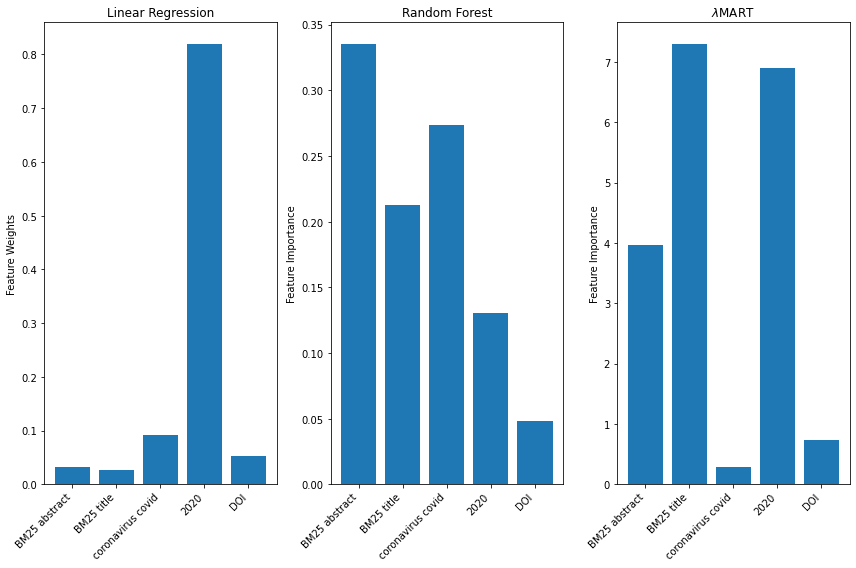

In [48]:
import numpy as np
from matplotlib import pyplot as plt

# Create figure
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 8))

# Plot Linear Regression model weights
ax0.bar(np.arange(len(fnames)), lr.coef_)
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Linear Regression")
ax0.set_ylabel("Feature Weights")
# Plot Random Forest feature importance
ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forest")
ax1.set_ylabel("Feature Importance")
# Plot LmbdaMART feature importance
ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART")
ax2.set_ylabel("Feature Importance")

# Display figure
plt.tight_layout()
plt.show()
